In [14]:
from collections import defaultdict
import pandas as pd
import numpy as np
import io
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
#nltk.download () # Download only required or all -> press d, type all, type quit after
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix, recall_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [15]:
train_path = "content/training.csv"
val_path = "content/validation.csv"
test_path = "content/test.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

<BarContainer object of 6 artists>

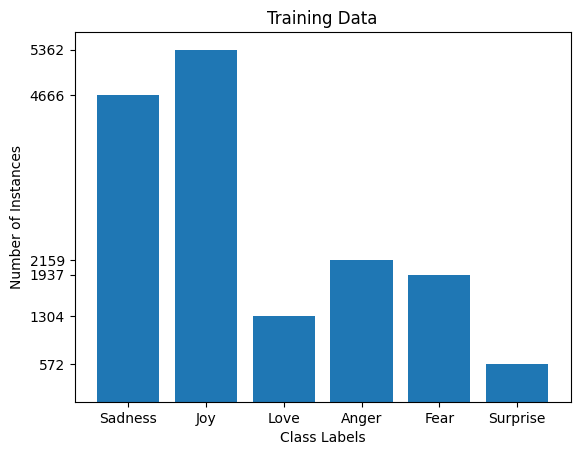

In [16]:
sadness = train_df[train_df['label'] == 0]
joy = train_df[train_df['label'] == 1]
love = train_df[train_df['label'] == 2]
anger = train_df[train_df['label'] == 3]
fear = train_df[train_df['label'] == 4]
suprise = train_df[train_df['label'] == 5]

x = ["Sadness", "Joy", "Love", "Anger", "Fear", "Surprise"]
y = [len(sadness), len(joy), len(love), len(anger), len(fear), len(suprise)]

plt.yticks(y)
plt.xlabel("Class Labels")
plt.ylabel("Number of Instances")
plt.title("Training Data")
plt.bar(x,y)

Tokenization method to tokenize our datasets

In [17]:
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()]  

In [18]:
train_df['tokenized'] = train_df.apply(lambda x: tokenize(x['text']), axis=1)
val_df['tokenized'] = val_df.apply(lambda x: tokenize(x['text']), axis=1)
test_df['tokenized'] = test_df.apply(lambda x: tokenize(x['text']), axis=1)

print(train_df['tokenized'])

0                             [i, didnt, feel, humiliated]
1        [i, can, go, from, feeling, so, hopeless, to, ...
2        [im, grabbing, a, minute, to, post, i, feel, g...
3        [i, am, ever, feeling, nostalgic, about, the, ...
4                                [i, am, feeling, grouchy]
                               ...                        
15995    [i, just, had, a, very, brief, time, in, the, ...
15996    [i, am, now, turning, and, i, feel, pathetic, ...
15997                [i, feel, strong, and, good, overall]
15998    [i, feel, like, this, was, such, a, rude, comm...
15999    [i, know, a, lot, but, i, feel, so, stupid, be...
Name: tokenized, Length: 16000, dtype: object


In [19]:
lmtzr = WordNetLemmatizer()
train_df['lemmatized'] = train_df['tokenized'].apply(
                    lambda lst:[lmtzr.lemmatize(word) for word in lst])
train_df.lemmatized = train_df.lemmatized.str.join(sep=' ')
val_df['lemmatized'] = val_df['tokenized'].apply(
                   lambda lst:[lmtzr.lemmatize(word) for word in lst])
val_df.lemmatized = val_df.lemmatized.str.join(sep=' ')
test_df['lemmatized'] = test_df['tokenized'].apply(
                   lambda lst:[lmtzr.lemmatize(word) for word in lst])
test_df.lemmatized = test_df.lemmatized.str.join(sep=' ')

Stemming (Just experimented and decided to continue with lemmatizaiton)

In [20]:
stemmer = SnowballStemmer("english")
train_df['stemmed'] = train_df.tokenized.map(lambda l: [stemmer.stem(word) for word in l])
train_df.stemmed = train_df.stemmed.str.join(sep=' ')

val_df['stemmed'] = val_df.tokenized.map(lambda l: [stemmer.stem(word) for word in l])
val_df.stemmed = val_df.stemmed.str.join(sep=' ')

test_df['stemmed'] = test_df.tokenized.map(lambda l: [stemmer.stem(word) for word in l])
test_df.stemmed = test_df.stemmed.str.join(sep=' ')

Preprocessing...

In [21]:
cv = CountVectorizer(stop_words='english')
train_ppd_df = cv.fit_transform(train_df["lemmatized"])
val_ppd_df = cv.transform(val_df["lemmatized"])
test_ppd_df = cv.transform(test_df["lemmatized"])


display(train_ppd_df)
display(val_ppd_df)
display(test_ppd_df)

<16000x13293 sparse matrix of type '<class 'numpy.int64'>'
	with 132214 stored elements in Compressed Sparse Row format>

<2000x13293 sparse matrix of type '<class 'numpy.int64'>'
	with 15526 stored elements in Compressed Sparse Row format>

<2000x13293 sparse matrix of type '<class 'numpy.int64'>'
	with 15601 stored elements in Compressed Sparse Row format>

In [22]:
train_labels = np.array(train_df['label'])
val_labels = np.array(val_df['label'])
test_labels = np.array(test_df['label'])

In [23]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Oranges", ax=ax, colorbar=False)
    plt.show()

Now training our model with Multinomial Naive Bayes and testing the accuracy with validation data

In [24]:
mnb = MultinomialNB()
mnb.fit(train_ppd_df,train_labels)
val_predictions_NB = mnb.predict(val_ppd_df)

print("Accuracy Score -> ",accuracy_score(val_predictions_NB, val_labels)*100)
confusion_matrix(y_true=val_labels, y_pred=val_predictions_NB)

Accuracy Score ->  80.35


array([[517,  19,   1,   6,   6,   1],
       [ 30, 664,   5,   4,   1,   0],
       [ 35,  72,  70,   0,   1,   0],
       [ 45,  29,   0, 197,   4,   0],
       [ 36,  23,   0,   6, 146,   1],
       [ 26,  30,   0,   1,  11,  13]])

Now testing the accuracy with test data

Accuracy Score ->  79.45


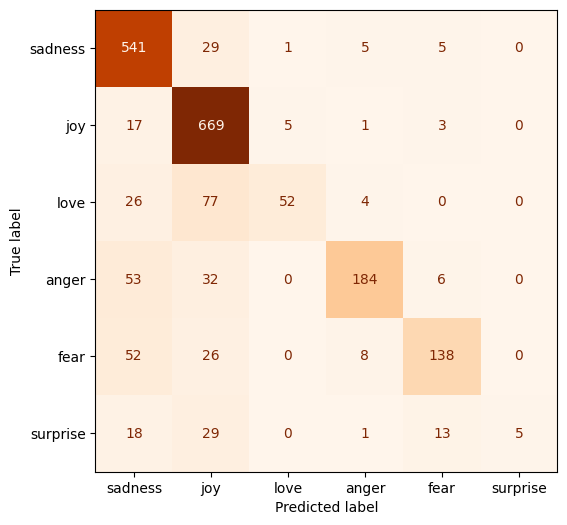

In [26]:
predictions_NB = mnb.predict(test_ppd_df)

print("Accuracy Score -> ",accuracy_score(predictions_NB, test_labels)*100)
confusion_matrix(y_true=test_labels, y_pred=predictions_NB)
labels = ["sadness","joy", "love", "anger", "fear","surprise"]
plot_confusion_matrix(y_true=test_labels, y_preds=predictions_NB, labels=labels)

In [ ]:
alphas = [0, 0.001, 0.01, 0.1, 1, 10]
ls_accuracies = []
for alpha in alphas:
    mnb_ls = MultinomialNB(alpha=alpha)
    mnb_ls.fit(train_ppd_df,train_labels)
    predictions_NB = mnb_ls.predict(test_ppd_df)
    accuracy = accuracy_score(predictions_NB, test_labels)*100
    ls_accuracies.append(accuracy)
    print("Multinomial Naive Bayes Accuracy Score on alpha ", alpha, " -> ", accuracy, "%")

Multinomial Naive Bayes Accuracy Score on alpha  0  ->  72.1 %
Multinomial Naive Bayes Accuracy Score on alpha  0.001  ->  72.89999999999999 %
Multinomial Naive Bayes Accuracy Score on alpha  0.01  ->  74.45 %
Multinomial Naive Bayes Accuracy Score on alpha  0.1  ->  79.85 %
Multinomial Naive Bayes Accuracy Score on alpha  1  ->  79.45 %
Multinomial Naive Bayes Accuracy Score on alpha  10  ->  62.3 %


/opt/homebrew/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
